In [1]:
from pymatgen.io.vasp import Xdatcar
import numpy as np
from collections import Counter
import tqdm
import matplotlib.pyplot as plt
import yaml

import sys
sys.path.insert(0, "../../scripts/")
from utils import flatten_list, indices_by_species

from site_analysis_functions import (percolating_graph, 
                                     minimum_percolating_graph,
                                     t_all, s_sites,
                                     tetrahedral_site_analysis,
                                     pbc_nearest_point)

In [2]:
with open('../md_runs.yaml', 'r') as f:
    md_runs = yaml.safe_load(f)
print(md_runs)

{'Li6PS5I': {'0p': [1, 2, 3, 4, 5, 6], '50p': [1, 2, 3, 4, 5, 6, 7], '100p': [1, 2, 3, 4, 5, 6, 7]}, 'Li6PS5Cl': {'0p': [1, 2, 3, 4, 5], '50p': [1, 2, 3, 4, 5, 6], '100p': [1, 2, 3, 4, 5, 6]}}


In [3]:
data_dir = '../../data'

x_spec = {'Li6PS5I': 'I', 'Li6PS5Cl': 'Cl'}

analysis = {}
lattice = {}
for system in md_runs:
    analysis[system] = {}
    lattice[system] = {}
    for disorder, runs in md_runs[system].items():
        xdatcar_filenames = [f'{data_dir}/{system}/{disorder}/run{i}/inherent_XDATCAR.gz' for i in runs]
        xdatcars = [Xdatcar( f ) for f in xdatcar_filenames]
        structures = flatten_list([x.structures for x in xdatcars])
        analysis[system][disorder] = tetrahedral_site_analysis(structures, x_spec[system])
        lattice[system][disorder] = structures[0].lattice

max mapping disp = 0.26 Angstroms


100%|██████████| 700/700 [17:22<00:00,  1.49s/ steps]


max mapping disp = 0.58 Angstroms


100%|██████████| 700/700 [09:33<00:00,  1.22 steps/s]


max mapping disp = 0.43 Angstroms


100%|██████████| 700/700 [07:51<00:00,  1.49 steps/s]


max mapping disp = 0.89 Angstroms


100%|██████████| 700/700 [15:24<00:00,  1.32s/ steps]


max mapping disp = 0.78 Angstroms


100%|██████████| 700/700 [11:38<00:00,  1.00 steps/s]


max mapping disp = 0.60 Angstroms


100%|██████████| 700/700 [41:06<00:00,  3.52s/ steps]    


In [4]:
from matplotlib import rcParams

rcParams['font.serif'] = "Iowan Old Style"
rcParams['font.family'] = "serif"
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Iowan Old Style'
rcParams['mathtext.it'] = 'Iowan Old Style:italic'
rcParams['mathtext.bf'] = 'Iowan Old Style:bold'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams.update({'font.size': 20})

In [7]:
from vasppy.rdf import RadialDistributionFunction
from pymatgen import PeriodicSite
from pymatgen import Structure

atoms = { '1': 'Ca',
          '2': 'Na',
          '4': 'K',
          '5': 'Li' }

r_max = 3.5
         
rdf_data = {}
r_perc = {}
i=-1
for disorder in ['0p', '50p', '100p']:
    for system in ['Li6PS5I', 'Li6PS5Cl']:
        if not system in rdf_data:
            rdf_data[system] = {}
            r_perc[system] = {}
        rdf_data[system][disorder] = {}
        r_perc[system][disorder] = {}

        a = analysis[system][disorder]
        latt = lattice[system][disorder] 

        new_sites = []

        for s in a.sites:
            if s.points:
                points = np.array([pbc_nearest_point(s.centre(), p) for p in s.points])
                new_sites.append(PeriodicSite(coords=np.mean(points, axis=0), 
                                              species=atoms[s.label], lattice=latt))

        li_struct = Structure.from_sites(new_sites)
        elements = set( [ s.species_string for s in new_sites ] )
        r_perc[system][disorder] = minimum_percolating_graph(structure=li_struct,
                                                             elements=elements,
                                                             r_min=0.1,
                                                             r_max=3.0,
                                                             func=percolating_graph,
                                                             verbose=False)['x']

        li_indices = indices_by_species( li_struct, 'Li' )
        na_indices = indices_by_species( li_struct, 'Na' )
        k_indices = indices_by_species( li_struct, 'K' )

        rdf_data[system][disorder]['55'] = RadialDistributionFunction(
            [li_struct], li_indices, li_indices, r_max=r_max)
        rdf_data[system][disorder]['52'] = RadialDistributionFunction(
            [li_struct], li_indices, na_indices, r_max=r_max)
        rdf_data[system][disorder]['22'] = RadialDistributionFunction(
            [li_struct], na_indices, na_indices, r_max=r_max)
        if k_indices:
            rdf_data[system][disorder]['54'] = RadialDistributionFunction(
                [li_struct], li_indices, k_indices, r_max=r_max)
            rdf_data[system][disorder]['24'] = RadialDistributionFunction(
                [li_struct], na_indices, k_indices, r_max=r_max)


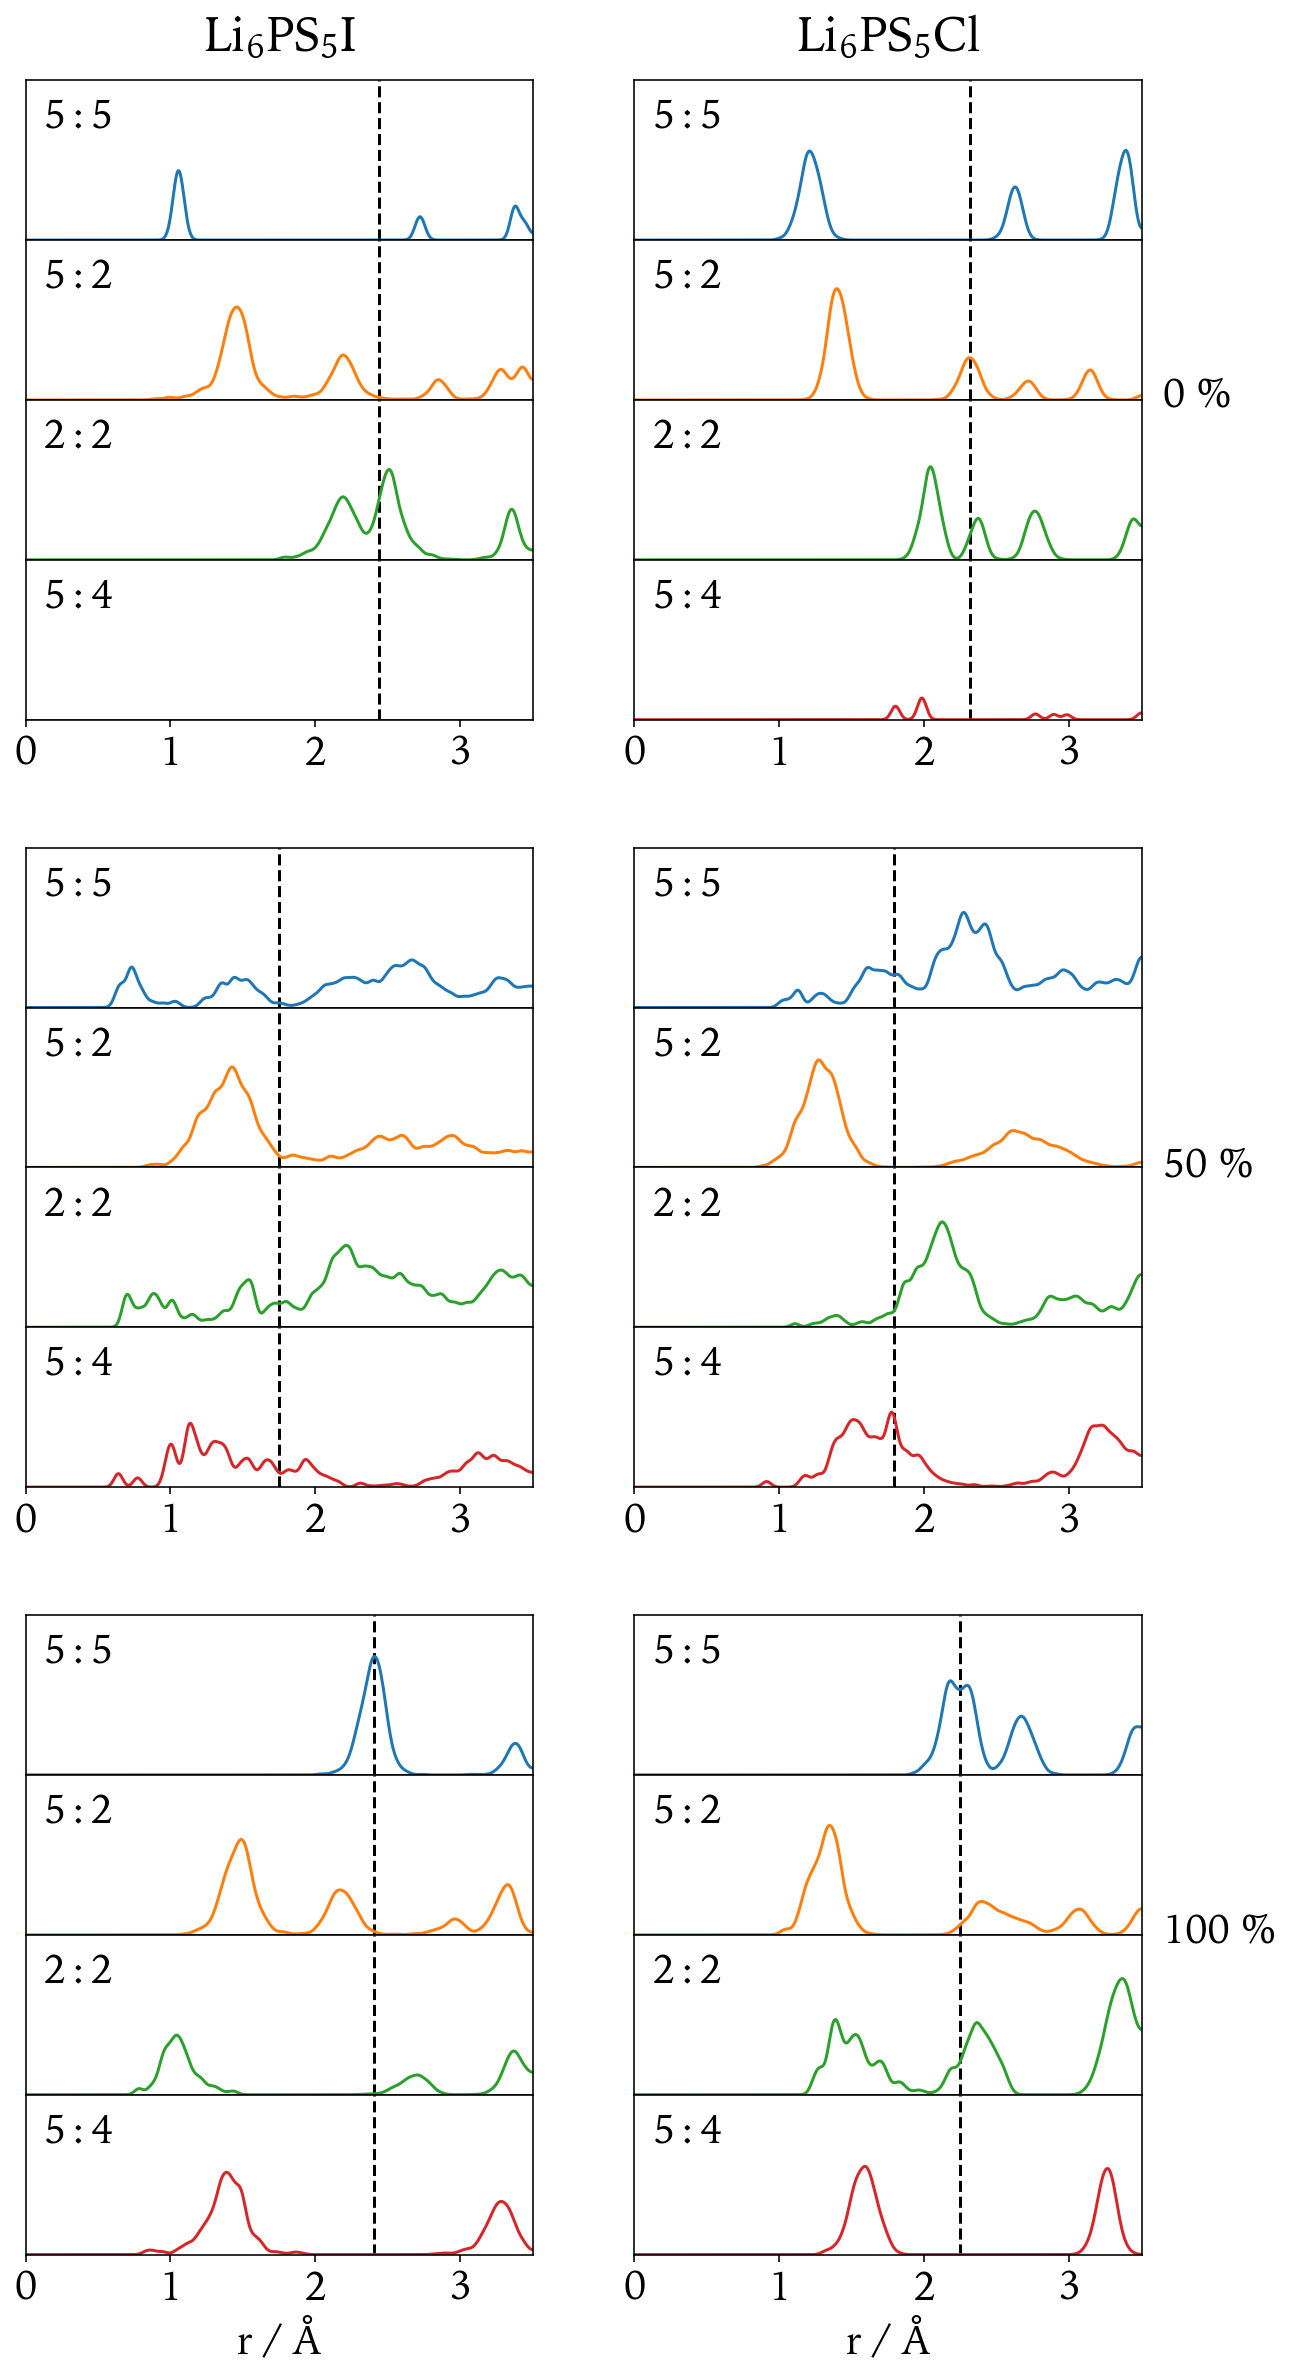

In [9]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 20))
outer = gridspec.GridSpec(3, 2, wspace=0.2, hspace=0.2)

j_map = {0: '55',
         1: '52',
         2: '22',
         3: '54'}

labels = {'55': '5-5',
          '52': '5-2',
          '22': '2-2',
          '54': '5-4'}

colours = {'55': '#1f77b4',
           '52': '#ff7f0e',
           '22': '#2ca02c',
           '54': '#d62728'}

sigma = 0.03

i=-1
for disorder in ['0p', '50p', '100p']:
    for system in ['Li6PS5I', 'Li6PS5Cl']:
        i += 1
        inner = gridspec.GridSpecFromSubplotSpec(4, 1,
                        subplot_spec=outer[i], wspace=0.1, hspace=0.0)
                
        for j in range(4):
            axes = plt.Subplot(fig, inner[j])
            k = j_map[j]
            try:
                rdf = rdf_data[system][disorder][k]
                axes.plot(rdf.r, rdf.smeared_rdf(sigma=sigma), 
                          label=labels[k], c=colours[k])
                y_max = rdf.rdf.max()*1.1
            except:
                x = np.linspace(0,r_max)
                y = np.zeros_like(x)
                axes.plot(x,y, c=colours[k])
                y_max = 1.0
            axes.vlines(r_perc[system][disorder], 0, y_max, linestyles='dashed', color='black')
            axes.set_yticks([])
            if j in [0,1,2]:
                axes.set_xticks([])
            axes.set_xlim([0,r_max])
            axes.set_ylim([0,y_max])
            fig.add_subplot(axes)
            if i in [4,5]:
                if j == 3:
                    axes.set_xlabel(r'$r$ / $\mathrm{\AA}$')
            if i == 0:
                if j == 0:
                    axes.set_title(r'Li$_6$PS$_5$I', pad=15)
            if i == 1:
                if j == 0:
                    axes.set_title(r'Li$_6$PS$_5$Cl', pad=15)
                if j == 1:
                    axes.text(3.65,-0.5,'0 %')
            if i == 3:
                if j == 1:
                    axes.text(3.65,-0.5,'50 %')
            if i == 5:
                if j == 1:
                    axes.text(3.65,-0.5,'100 %')
            if j == 0:
                axes.text(0.12,y_max*0.7,r'$5:5$')
            if j == 1:
                axes.text(0.12,y_max*0.7,r'$5:2$')
            if j == 2:
                axes.text(0.12,y_max*0.7,r'$2:2$')
            if j == 3:
                axes.text(0.12,y_max*0.7,r'$5:4$')
fig.tight_layout()
fig.show()

In [10]:
fig.savefig('../../figures/site_rdf.pdf', bbox_inches='tight')

In [11]:
%load_ext version_information

%version_information yaml, matplotlib, numpy, pymatgen, site_analysis

Software versions
Python 3.7.7 64bit [Clang 11.0.3 (clang-1103.0.32.62)]
IPython 7.19.0
OS Darwin 19.6.0 x86_64 i386 64bit
yaml 5.3.1
matplotlib 3.3.3
numpy 1.19.4
pymatgen 2020.12.3
site_analysis 0.0.2
Mon Dec 07 19:50:23 2020 GMT